# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook  - ***13 points***
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework) 
- homework_differentiation.ipynb -  ***2 points***

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

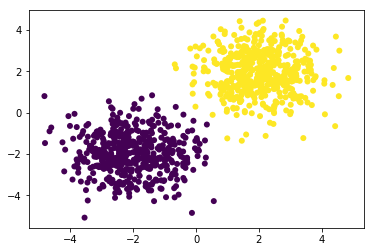

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 2))
net.add(ReLU())
# net.add(Linear(4, 2))
net.add(LogSoftMax())

#criterion = MSECriterion()

print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 2
ReLU
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

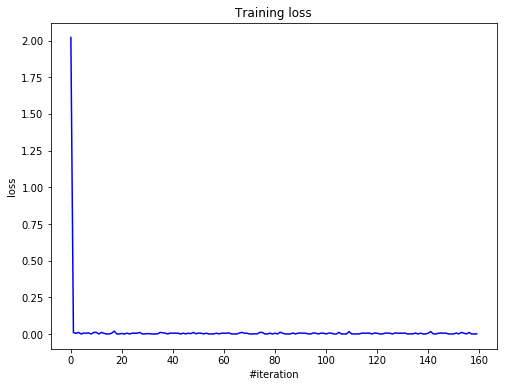

Current loss: 0.000648


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten = True)

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(categories = [range(10)], sparse=False)
y_ohe = OHE.fit_transform(y_train.reshape(-1, 1))
y_test_ohe = OHE.fit_transform(y_test.reshape(-1, 1))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison. Write your personal opinion on the activation functions, think about computation times too. Plot the losses both from activation functions comparison comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking. ***2.5 points***
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions. Plot the losses both for the `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.  Does `BatchNormalization` help? ***2.5 points***

- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better? ***2.5 points***
- Increase the number of parameters in the network. Try inserting the Dropout layer. Compare the validation performance and the gap between test and validation performances for the two experiments (with and without Dropout). Compare the loss plots. Which one converges slower? ***2.5 points***


In [35]:
# Your code goes here. ################################################
def train(net, X, Y, activat, criterion, X_test, y_test, norm = False, n_epoch=20, batch_size=500, learning_rate=0.001, momentum=0.9, opt = False):

    if norm == False:
        net.add(Linear(784, 64))
        net.add(activat)
        net.add(Linear(64, 10))
        net.add(LogSoftMax())

    else:
        net.add(Linear(784, 64))
        net.add(BatchNormalization(0.01))
        net.add(ChannelwiseScaling(64))
        net.add(activat)
        net.add(Linear(64, 10))
        net.add(LogSoftMax())

    loss_history = []
    loss_history_epoch = []
    acc = []
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            if opt == False:
                # Iptimizer params
                optimizer_config = {'learning_rate' : learning_rate, 'momentum': momentum}
                optimizer_state = {}
                sgd_momentum(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state) 
            else:
                # Iptimizer params
                optimizer_config = {'learning_rate' : 1e-3, 'beta1' :0.9, 'beta2' : 0.99, 'epsilon' : 10e-4}
                optimizer_state = {}
                adam_optimizer(net.getParameters(), 
                             net.getGradParameters(), 
                             optimizer_config,
                             optimizer_state) 
                
            loss_history.append(loss)
        net.evaluate()
        y_pred_test = net.forward(X_test)
        acc.append(get_accuracy(y_pred_test, np.argmax(y_test, axis=1)))
        l = criterion.forward(y_pred_test, y_test)
        loss_history_epoch.append(l)
    return acc, loss_history, loss_history_epoch

def get_accuracy(y_pred, y_true):
    res = np.argmax(y_pred, axis=1)
    accuracy = np.sum(res == y_true) / len(res)
    return accuracy

### ClassNLLCriterion

In [36]:
import time
import pandas as pd

In [37]:
start_time_ReLU = time.time()
net = Sequential()
activat_ReLU = ReLU()
criterion = ClassNLLCriterion()
acc_ReLU, loss_history_ReLU, l_ReLU = train(net, X_train, y_ohe, activat_ReLU, criterion, X_test, y_test_ohe)
time_ReLU = (time.time() - start_time_ReLU)

start_time_ELU = time.time()
net1 = Sequential()
activat_ELU = ELU()
criterion = ClassNLLCriterion()
acc_ELU, loss_history_ELU, l_ELU = train(net1, X_train, y_ohe, activat_ELU, criterion,  X_test, y_test_ohe)
time_ELU = (time.time() - start_time_ELU)


start_time_LeakyReLU = time.time()
net2 = Sequential()
activat_LeakyReLU = LeakyReLU()
criterion = ClassNLLCriterion()
acc_LeakyReLU, loss_history_LeakyReLU, l_Leaky_ReLU = train(net2, X_train, y_ohe, activat_LeakyReLU, 
                                                            criterion,  X_test, y_test_ohe)
time_LeakyReLU  = (time.time() - start_time_LeakyReLU )

start_time_SoftPlus = time.time()
net3 = Sequential()
activat_SoftPlus = SoftPlus()
criterion = ClassNLLCriterion()
acc_SoftPlus, loss_history_SoftPlus, l_SoftPlus = train(net3, X_train, y_ohe, activat_SoftPlus, 
                                                        criterion,  X_test, y_test_ohe)
time_SoftPlus  = (time.time() - start_time_SoftPlus )

In [38]:
plt.style.use('ggplot') 
%matplotlib inline

Text(0, 0.5, 'epoch')

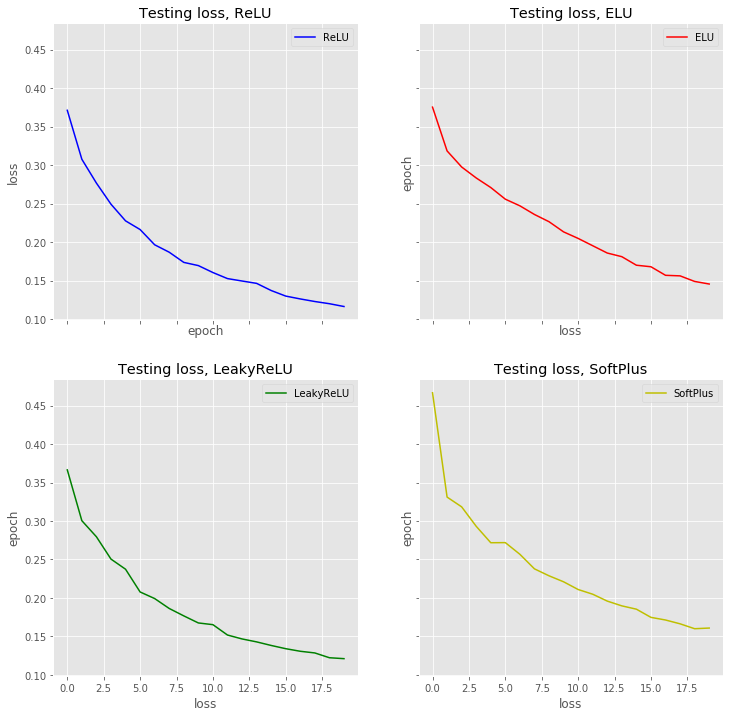

In [39]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)


axes[0][0].plot(l_ReLU, 'b', label = 'ReLU')
axes[0][0].set_title('Testing loss, ReLU')
axes[0][0].legend()
axes[0][0].set_ylabel("loss")
axes[0][0].set_xlabel('epoch')
axes[0][1].plot(l_ELU, 'r',label = 'ELU')
axes[0][1].set_title('Testing loss, ELU')
axes[0][1].legend()
axes[0][1].set_xlabel('loss')
axes[0][1].set_ylabel("epoch")
axes[1][0].plot(l_Leaky_ReLU, 'g',label = 'LeakyReLU')
axes[1][0].set_title('Testing loss, LeakyReLU')
axes[1][0].legend()
axes[1][0].set_xlabel('loss')
axes[1][0].set_ylabel("epoch")
axes[1][1].plot(l_SoftPlus, 'y',label = 'SoftPlus')
axes[1][1].set_title('Testing loss, SoftPlus')
axes[1][1].legend()
axes[1][1].set_xlabel('loss')
axes[1][1].set_ylabel("epoch")

Text(0, 0.5, 'loss')

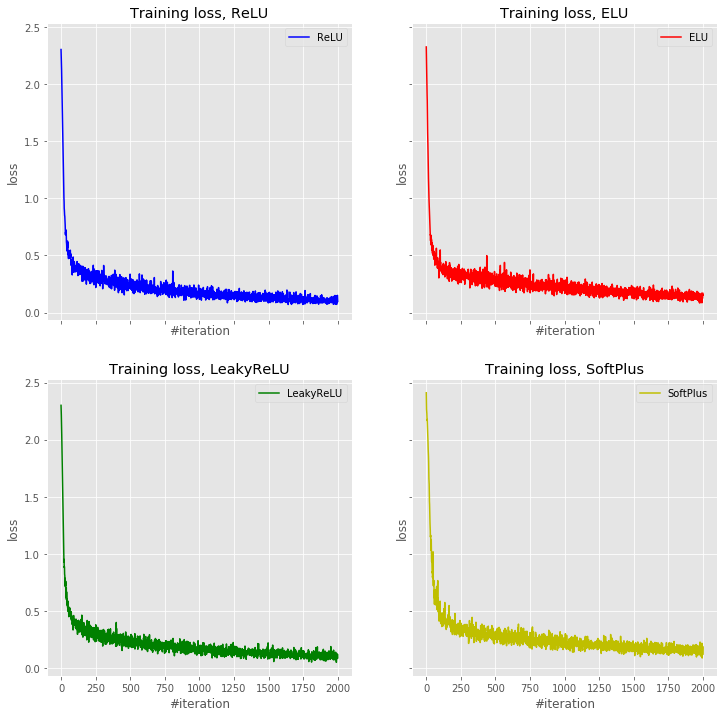

In [40]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)


axes[0][0].plot(loss_history_ReLU, 'b', label = 'ReLU')
axes[0][0].set_title('Training loss, ReLU')
axes[0][0].legend()
axes[0][0].set_ylabel("loss")
axes[0][0].set_xlabel('#iteration')
axes[0][1].plot(loss_history_ELU, 'r',label = 'ELU')
axes[0][1].set_title('Training loss, ELU')
axes[0][1].legend()
axes[0][1].set_xlabel('#iteration')
axes[0][1].set_ylabel("loss")
axes[1][0].plot(loss_history_LeakyReLU, 'g',label = 'LeakyReLU')
axes[1][0].set_title('Training loss, LeakyReLU')
axes[1][0].legend()
axes[1][0].set_xlabel('#iteration')
axes[1][0].set_ylabel("loss")
axes[1][1].plot(loss_history_SoftPlus, 'y',label = 'SoftPlus')
axes[1][1].set_title('Training loss, SoftPlus')
axes[1][1].legend()
axes[1][1].set_xlabel('#iteration')
axes[1][1].set_ylabel("loss")

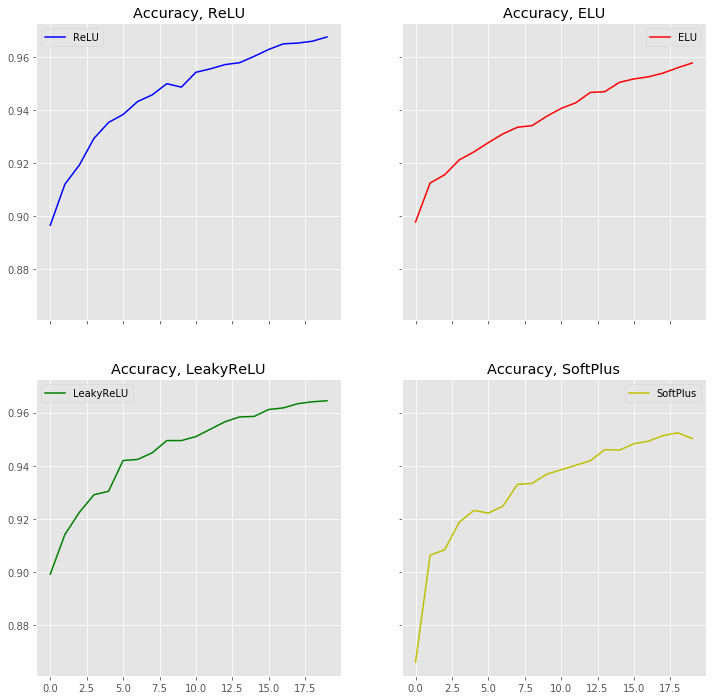

In [42]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)


axes[0][0].plot(acc_ReLU, 'b', label = 'ReLU')
axes[0][0].set_title('Accuracy, ReLU')
axes[0][0].legend()
# axes[0][0].set_ylabel("loss")
# axes[0][0].set_xlabel('#iteration')
axes[0][1].plot(acc_ELU, 'r',label = 'ELU')
axes[0][1].set_title('Accuracy, ELU')
axes[0][1].legend()
# axes[0][1].set_xlabel('#iteration')
# axes[0][1].set_ylabel("loss")
axes[1][0].plot(acc_LeakyReLU, 'g',label = 'LeakyReLU')
axes[1][0].set_title('Accuracy, LeakyReLU')
axes[1][0].legend()
# axes[1][0].set_xlabel('#iteration')
# axes[1][0].set_ylabel("loss")
axes[1][1].plot(acc_SoftPlus, 'y',label = 'SoftPlus')
axes[1][1].set_title('Accuracy, SoftPlus')
axes[1][1].legend()
# axes[1][1].set_xlabel('#iteration')
# axes[1][1].set_ylabel("loss")

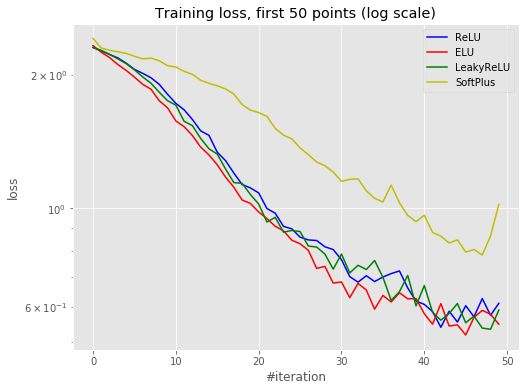

In [43]:
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))
plt.title("Training loss, first 50 points (log scale)")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_ReLU[:50], 'b', label = 'ReLU')
plt.plot(loss_history_ELU[:50], 'r',label = 'ELU')
plt.plot(loss_history_LeakyReLU[:50], 'g',label = 'LeakyReLU')
plt.plot(loss_history_SoftPlus[:50], 'y',label = 'SoftPlus')
plt.legend()
plt.yscale('log')
plt.show()

In [44]:
print('Current loss of ReLU: %f' % loss_history_ReLU[-1])
print('Current loss of ELU: %f' % loss_history_ELU[-1])
print('Current loss of LeakyReLU: %f' % loss_history_LeakyReLU[-1])
print('Current loss of SoftPlus: %f' % loss_history_SoftPlus[-1])

Current loss of ReLU: 0.096733
Current loss of ELU: 0.166936
Current loss of LeakyReLU: 0.091407
Current loss of SoftPlus: 0.124027


### BatchNormalization

In [45]:
%run homework_modules.ipynb


start_time_ReLU_b = time.time()
net_b = Sequential()
criterion = ClassNLLCriterion()
acc_ReLU_b, loss_history_relu_b, l_ReLU_b  = train(net_b, X_train, y_ohe, activat_ReLU, criterion, X_test, y_test_ohe, norm = True)
time_ReLU_b = (time.time() - start_time_ReLU_b)

start_time_ELU_b = time.time()
net_b1 = Sequential()
acc_ELU_b, loss_history_ELU_b, l_ELU_b  = train(net_b1, X_train, y_ohe, activat_ELU, criterion, X_test, y_test_ohe,norm = True)
time_ELU_b = (time.time() - start_time_ELU_b)

start_time_LeakyReLU_b = time.time()
net_b2 = Sequential()
acc_LeakyReLU_b, loss_history_LeakyReLU_b, l_Leaky_ReLU_b = train(net_b2, X_train, y_ohe, activat_LeakyReLU, criterion, X_test, y_test_ohe,norm = True)
time_LeakyReLU_b = (time.time() - start_time_LeakyReLU_b)

start_time_SoftPlus_b = time.time()
net_b3 = Sequential()
acc_SoftPlus_b, loss_history_SoftPlus_b , l_SoftPlus_b = train(net_b3, X_train, y_ohe, activat_SoftPlus, criterion,X_test, y_test_ohe, norm = True)
time_SoftPlus_b = (time.time() - start_time_SoftPlus_b)



Text(0, 0.5, 'epoch')

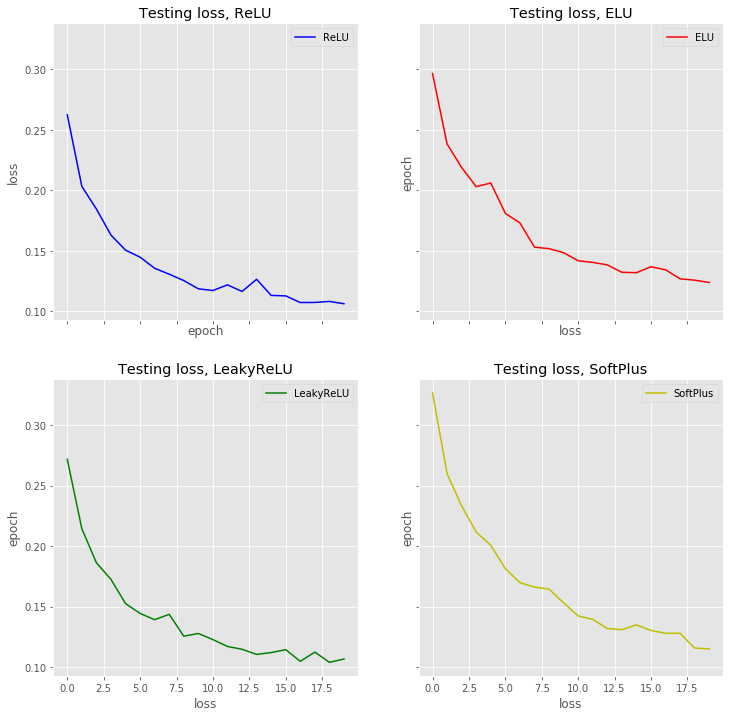

In [46]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)


axes[0][0].plot(l_ReLU_b, 'b', label = 'ReLU')
axes[0][0].set_title('Testing loss, ReLU')
axes[0][0].legend()
axes[0][0].set_ylabel("loss")
axes[0][0].set_xlabel('epoch')
axes[0][1].plot(l_ELU_b, 'r',label = 'ELU')
axes[0][1].set_title('Testing loss, ELU')
axes[0][1].legend()
axes[0][1].set_xlabel('loss')
axes[0][1].set_ylabel("epoch")
axes[1][0].plot(l_Leaky_ReLU_b, 'g',label = 'LeakyReLU')
axes[1][0].set_title('Testing loss, LeakyReLU')
axes[1][0].legend()
axes[1][0].set_xlabel('loss')
axes[1][0].set_ylabel("epoch")
axes[1][1].plot(l_SoftPlus_b, 'y',label = 'SoftPlus')
axes[1][1].set_title('Testing loss, SoftPlus')
axes[1][1].legend()
axes[1][1].set_xlabel('loss')
axes[1][1].set_ylabel("epoch")

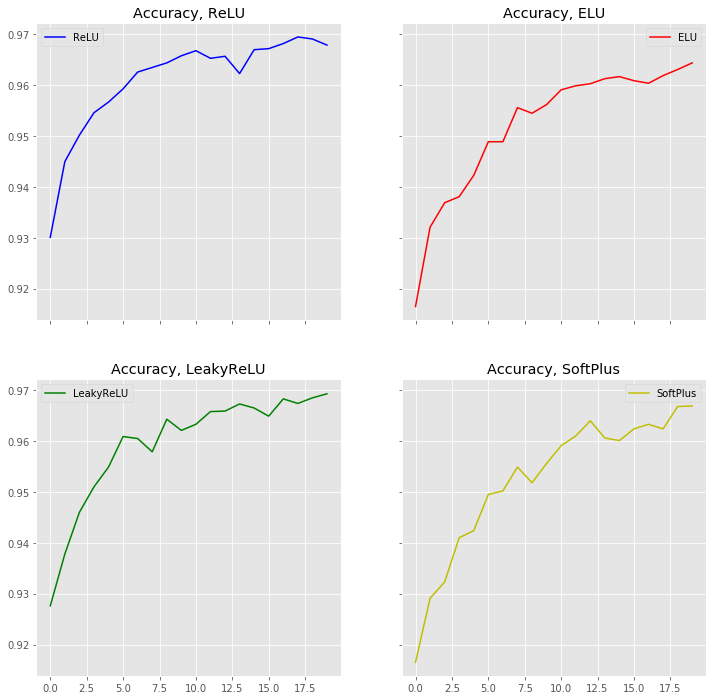

In [47]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)


axes[0][0].plot(acc_ReLU_b, 'b', label = 'ReLU')
axes[0][0].set_title('Accuracy, ReLU')
axes[0][0].legend()
# axes[0][0].set_ylabel("loss")
# axes[0][0].set_xlabel('#iteration')
axes[0][1].plot(acc_ELU_b, 'r',label = 'ELU')
axes[0][1].set_title('Accuracy, ELU')
axes[0][1].legend()
# axes[0][1].set_xlabel('#iteration')
# axes[0][1].set_ylabel("loss")
axes[1][0].plot(acc_LeakyReLU_b, 'g',label = 'LeakyReLU')
axes[1][0].set_title('Accuracy, LeakyReLU')
axes[1][0].legend()
# axes[1][0].set_xlabel('#iteration')
# axes[1][0].set_ylabel("loss")
axes[1][1].plot(acc_SoftPlus_b, 'y',label = 'SoftPlus')
axes[1][1].set_title('Accuracy, SoftPlus')
axes[1][1].legend()
# axes[1][1].set_xlabel('#iteration')
# axes[1][1].set_ylabel("loss")

Text(0, 0.5, 'loss')

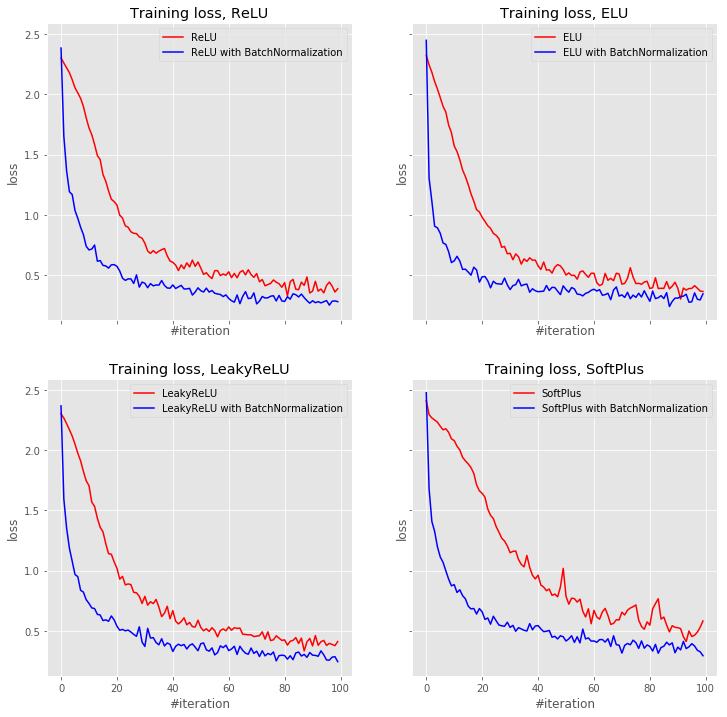

In [48]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)

axes[0][0].plot(loss_history_ReLU[:100], 'r', label = 'ReLU')
axes[0][0].plot(loss_history_relu_b[:100], 'b', label = 'ReLU with BatchNormalization')
axes[0][0].set_title('Training loss, ReLU')
axes[0][0].legend()
axes[0][0].set_ylabel("loss")
axes[0][0].set_xlabel('#iteration')
axes[0][1].plot(loss_history_ELU[:100], 'r',label = 'ELU')
axes[0][1].plot(loss_history_ELU_b[:100], 'b', label = 'ELU with BatchNormalization')
axes[0][1].set_title('Training loss, ELU')
axes[0][1].legend()
axes[0][1].set_xlabel('#iteration')
axes[0][1].set_ylabel("loss")
axes[1][0].plot(loss_history_LeakyReLU[:100], 'r',label = 'LeakyReLU')
axes[1][0].plot(loss_history_LeakyReLU_b[:100], 'b', label = 'LeakyReLU with BatchNormalization')
axes[1][0].set_title('Training loss, LeakyReLU')
axes[1][0].legend()
axes[1][0].set_xlabel('#iteration')
axes[1][0].set_ylabel("loss")
axes[1][1].plot(loss_history_SoftPlus[:100], 'r',label = 'SoftPlus')
axes[1][1].plot(loss_history_SoftPlus_b[:100], 'b', label = 'SoftPlus with BatchNormalization')
axes[1][1].set_title('Training loss, SoftPlus')
axes[1][1].legend()
axes[1][1].set_xlabel('#iteration')
axes[1][1].set_ylabel("loss")

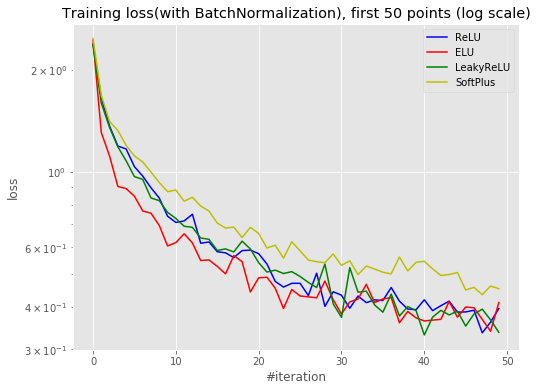

In [49]:
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))
plt.title("Training loss(with BatchNormalization), first 50 points (log scale)")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_relu_b[:50], 'b', label = 'ReLU')
plt.plot(loss_history_ELU_b[:50], 'r',label = 'ELU')
plt.plot(loss_history_LeakyReLU_b[:50], 'g',label = 'LeakyReLU')
plt.plot(loss_history_SoftPlus_b[:50], 'y',label = 'SoftPlus')
plt.legend()
plt.yscale('log')
plt.show()

In [50]:
print('Current loss of ReLU: %f' % loss_history_relu_b[-1])
print('Current loss of ELU: %f' % loss_history_ELU_b[-1])
print('Current loss of LeakyReLU: %f' % loss_history_LeakyReLU_b[-1])
print('Current loss of SoftPlus: %f' % loss_history_SoftPlus_b[-1])

Current loss of ReLU: 0.042029
Current loss of ELU: 0.077263
Current loss of LeakyReLU: 0.066498
Current loss of SoftPlus: 0.076552


### Compare results

In [51]:
funcs_acc = {'ReLU':ReLU, 'ELU':ELU, 'LeakyReLU':LeakyReLU, 'SoftPlus':SoftPlus}

data_acc = [[acc_ReLU[-1], acc_ReLU_b[-1]], [acc_ELU[-1],acc_ELU_b[-1] ], [acc_LeakyReLU[-1],acc_LeakyReLU_b[-1]], [acc_SoftPlus[-1],acc_SoftPlus_b[-1]]]

acc_table = pd.DataFrame(data_acc, index=funcs_acc.keys(), columns=['Accuracy Without BatchNormalization','Accuracy With BatchNormalization'])


In [52]:
acc_table

,Accuracy Without BatchNormalization,Accuracy With BatchNormalization
ReLU,0.9675,0.9679
ELU,0.9577,0.9644
LeakyReLU,0.9645,0.9693
SoftPlus,0.9503,0.9669


In [53]:
funcs_time = {'ReLU':ReLU, 'ELU':ELU, 'LeakyReLU':LeakyReLU, 'SoftPlus':SoftPlus}

data_time = [[time_ReLU, time_ReLU_b], [time_ELU,time_ELU_b ], [time_LeakyReLU,time_LeakyReLU_b], [time_SoftPlus,time_SoftPlus_b]]

times_table = pd.DataFrame(data_time, index=funcs_time.keys(), columns=['TIME Without BatchNormalization','TIME With BatchNormalization'])

In [54]:
times_table

,TIME Without BatchNormalization,TIME With BatchNormalization
ReLU,30.976048,33.301946
ELU,31.392394,33.892753
LeakyReLU,31.222679,33.829406
SoftPlus,31.028689,33.707728


In [55]:
funcs = {'ReLU':ReLU, 'ELU':ELU, 'LeakyReLU':LeakyReLU, 'SoftPlus':SoftPlus}

data = [[loss_history_ReLU[-1],loss_history_relu_b[-1]], [loss_history_ELU[-1],loss_history_ELU_b[-1]], [loss_history_LeakyReLU[-1],loss_history_LeakyReLU_b[-1]], [loss_history_SoftPlus[-1],loss_history_SoftPlus_b[-1]]]

df = pd.DataFrame(data, index=funcs.keys(), columns=['Without BatchNormalization','With BatchNormalization'])

In [56]:
df

,Without BatchNormalization,With BatchNormalization
ReLU,0.096733,0.042029
ELU,0.166936,0.077263
LeakyReLU,0.091407,0.066498
SoftPlus,0.124027,0.076552


### Conclusion

_Accuracy:_ as we can see accuracy with Batch Normalization better then without. Such way we obtain results which on 0.4 - 1% above than without normalization. 

_Time:_ Obviously, that ReLU is the leader at the time, because its calculation is easier. Without normalization, there is a time spread from 30 to 31, whereas with normalization all the time is concentrated on 33.

_Loss:_ From paper(Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift): NB draws its strength from making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout.

### Adam optimizer

In [59]:
%run homework_modules.ipynb

start_time_ReLU_a = time.time()
net_a = Sequential()
criterion = ClassNLLCriterion()
loss_history_relu_a = train(net_a, X_train, y_ohe, activat_ReLU, criterion, X_test, y_test_ohe, opt = True)
time_ReLU_a = (time.time() - start_time_ReLU_a)

start_time_ELU_a = time.time()
net_a1 = Sequential()
loss_history_ELU_a = train(net_a1, X_train, y_ohe, activat_ELU, criterion, X_test, y_test_ohe, opt = True)
time_ELU_a = (time.time() - start_time_ELU_a)

start_time_LeakyReLU_a = time.time()
net_a2 = Sequential()
loss_history_LeakyReLU_a = train(net_a2, X_train, y_ohe, activat_LeakyReLU, criterion, X_test, y_test_ohe, opt = True)
time_LeakyReLU_a = (time.time() - start_time_LeakyReLU_a)

start_time_SoftPlus_a = time.time()
net_a3 = Sequential()
loss_history_SoftPlus_a = train(net_a3, X_train, y_ohe, activat_SoftPlus, criterion, X_test, y_test_ohe, opt = True)
time_SoftPlus_a = (time.time() - start_time_SoftPlus_a)

Text(0, 0.5, 'loss')

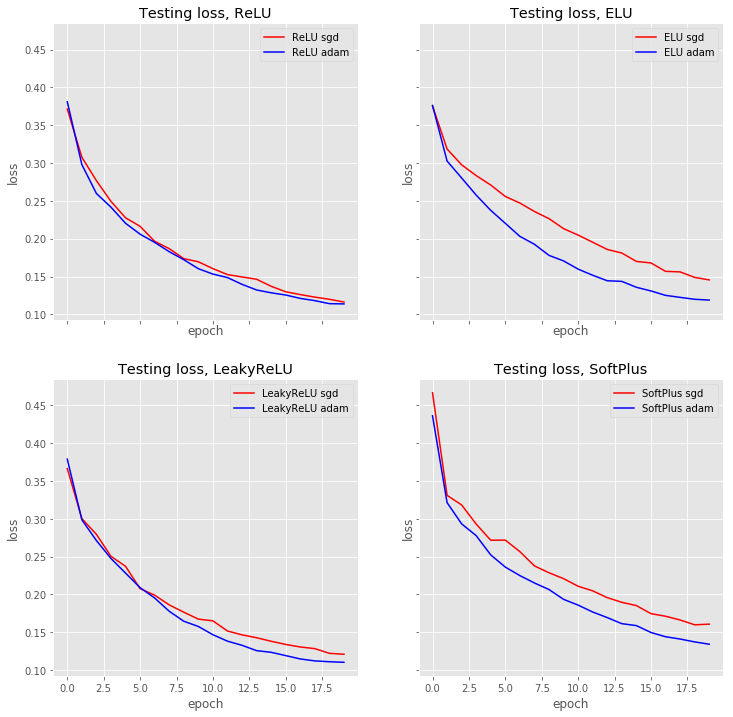

In [62]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)

axes[0][0].plot(l_ReLU, 'r', label = 'ReLU sgd')
axes[0][0].plot(loss_history_relu_a[2], 'b', label = 'ReLU adam')
axes[0][0].set_title('Testing loss, ReLU')
axes[0][0].legend()
axes[0][0].set_ylabel("loss")
axes[0][0].set_xlabel('epoch')
axes[0][1].plot(l_ELU, 'r',label = 'ELU sgd')
axes[0][1].plot(loss_history_ELU_a[2], 'b', label = 'ELU adam')
axes[0][1].set_title('Testing loss, ELU')
axes[0][1].legend()
axes[0][1].set_xlabel('epoch')
axes[0][1].set_ylabel("loss")
axes[1][0].plot(l_Leaky_ReLU, 'r',label = 'LeakyReLU sgd')
axes[1][0].plot(loss_history_LeakyReLU_a[2], 'b', label = 'LeakyReLU adam')
axes[1][0].set_title('Testing loss, LeakyReLU')
axes[1][0].legend()
axes[1][0].set_xlabel('epoch')
axes[1][0].set_ylabel("loss")
axes[1][1].plot(l_SoftPlus, 'r',label = 'SoftPlus sgd')
axes[1][1].plot(loss_history_SoftPlus_a[2], 'b', label = 'SoftPlus adam')
axes[1][1].set_title('Testing loss, SoftPlus')
axes[1][1].legend()
axes[1][1].set_xlabel('epoch')
axes[1][1].set_ylabel("loss")

As we can see Adam gives us better results on testing.

Text(0, 0.5, 'loss')

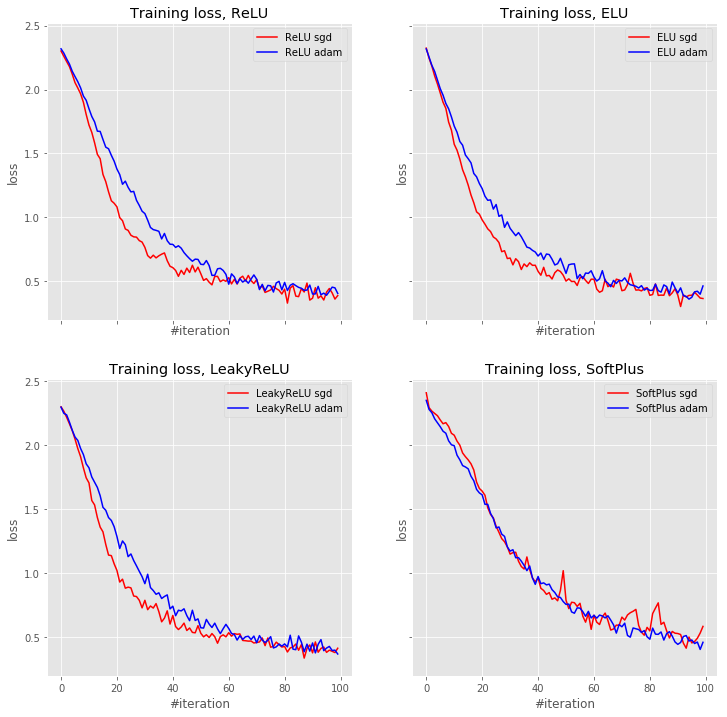

In [63]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)

axes[0][0].plot(loss_history_ReLU[:100], 'r', label = 'ReLU sgd ')
axes[0][0].plot(loss_history_relu_a[1][:100], 'b', label = 'ReLU adam')
axes[0][0].set_title('Training loss, ReLU')
axes[0][0].legend()
axes[0][0].set_ylabel("loss")
axes[0][0].set_xlabel('#iteration')
axes[0][1].plot(loss_history_ELU[:100], 'r',label = 'ELU sgd')
axes[0][1].plot(loss_history_ELU_a[1][:100], 'b', label = 'ELU adam')
axes[0][1].set_title('Training loss, ELU')
axes[0][1].legend()
axes[0][1].set_xlabel('#iteration')
axes[0][1].set_ylabel("loss")
axes[1][0].plot(loss_history_LeakyReLU[:100], 'r',label = 'LeakyReLU sgd')
axes[1][0].plot(loss_history_LeakyReLU_a[1][:100], 'b', label = 'LeakyReLU adam')
axes[1][0].set_title('Training loss, LeakyReLU')
axes[1][0].legend()
axes[1][0].set_xlabel('#iteration')
axes[1][0].set_ylabel("loss")
axes[1][1].plot(loss_history_SoftPlus[:100], 'r',label = 'SoftPlus sgd')
axes[1][1].plot(loss_history_SoftPlus_a[1][:100], 'b', label = 'SoftPlus adam')
axes[1][1].set_title('Training loss, SoftPlus')
axes[1][1].legend()
axes[1][1].set_xlabel('#iteration')
axes[1][1].set_ylabel("loss")

From the paper (Adam: A Method for Stochastic Optimization) : The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. 

So, as we can see, Adam Optimizer gives better results than SGD.

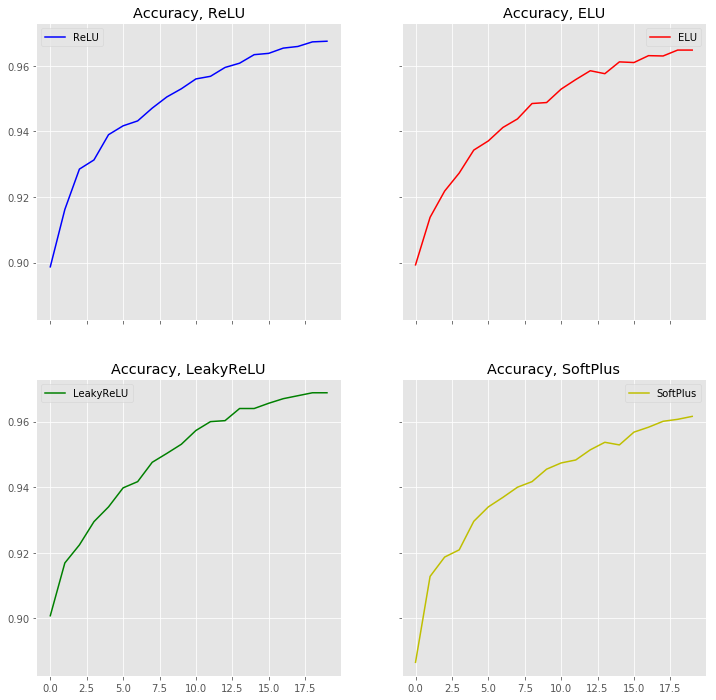

In [66]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)


axes[0][0].plot(loss_history_relu_a[0], 'b', label = 'ReLU')
axes[0][0].set_title('Accuracy, ReLU')
axes[0][0].legend()
# axes[0][0].set_ylabel("loss")
# axes[0][0].set_xlabel('#iteration')
axes[0][1].plot(loss_history_ELU_a[0], 'r',label = 'ELU')
axes[0][1].set_title('Accuracy, ELU')
axes[0][1].legend()
# axes[0][1].set_xlabel('#iteration')
# axes[0][1].set_ylabel("loss")
axes[1][0].plot(loss_history_LeakyReLU_a[0], 'g',label = 'LeakyReLU')
axes[1][0].set_title('Accuracy, LeakyReLU')
axes[1][0].legend()
# axes[1][0].set_xlabel('#iteration')
# axes[1][0].set_ylabel("loss")
axes[1][1].plot(loss_history_SoftPlus_a[0], 'y',label = 'SoftPlus')
axes[1][1].set_title('Accuracy, SoftPlus')
axes[1][1].legend()
# axes[1][1].set_xlabel('#iteration')
# axes[1][1].set_ylabel("loss")

In [67]:
funcs_acc_a = {'ReLU':ReLU, 'ELU':ELU, 'LeakyReLU':LeakyReLU, 'SoftPlus':SoftPlus}

data_acc_a = [[acc_ReLU[-1], loss_history_relu_a[0][-1]], [acc_ELU[-1],loss_history_ELU_a[0][-1] ], [acc_LeakyReLU[-1],loss_history_LeakyReLU_a[0][-1]], [acc_SoftPlus[-1],loss_history_SoftPlus_a[0][-1]]]

acc_table_a = pd.DataFrame(data_acc_a, index=funcs_acc_a.keys(), columns=['Accuracy SGD','Accuracy Adam'])



In [68]:
acc_table_a

,Accuracy SGD,Accuracy Adam
ReLU,0.9675,0.9675
ELU,0.9577,0.9648
LeakyReLU,0.9645,0.9688
SoftPlus,0.9503,0.9616


Adam is slightly better than SGD.

_______

_____

______

In [105]:
net_dr = Sequential()
net_dr.add(Linear(784, 64))
net_dr.add(BatchNormalization(0.1))
net_dr.add(ChannelwiseScaling(64))
net_dr.add(ReLU())
net_dr.add(Dropout())
net_dr.add(Linear(64, 10))
net_dr.add(LogSoftMax())

In [106]:
criterion = ClassNLLCriterion()

In [ ]:
loss_history_dr = []
acc_dr = []

loss_dr_test  = []

n_epoch = 40
batch_size = 64

start_time_dr =  time.time()
for i in range(n_epoch):
        for x_batch_dr, y_batch_dr in get_batches((X_train, y_ohe), batch_size):

            net_dr.zeroGradParameters()

            # Forward
            predictions_dr = net_dr.forward(x_batch_dr)
            loss_dr = criterion.forward(predictions_dr, y_batch_dr)

            # Backward
            dp_dr = criterion.backward(predictions_dr, y_batch_dr)
            net_dr.backward(x_batch_dr, dp_dr)

            # Update weights
            # Iptimizer params
            optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.9}
            optimizer_state = {}
            
            sgd_momentum(net_dr.getParameters(), 
                             net_dr.getGradParameters(), 
                             optimizer_config,
                             optimizer_state) 

                
            loss_history_dr.append(loss_dr)
            
            net_dr.evaluate()
            
            predictions_dr_test = net_dr.forward(X_test)
            
            predictions_dr_test1 = np.argmax(predictions_dr_test, axis=1)
            
            l = criterion.forward(predictions_dr_test1, y_test)
            
            acc_dr.append(get_accuracy(predictions_dr_test, y_test))
            
            loss_dr_test.append(l)
        
time_dr = (time.time() - start_time_dr)

In [ ]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Testing and Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_dr_test[:50], 'b', label = 'Test')
plt.plot(loss_history_dr[:50], 'g', label = 'Train')
plt.legend()
plt.show()

print('Current loss (Test): %f' % loss_dr_test[-1]) 
print('Current loss (Train): %f' % loss_history_dr[-1]) 

In [ ]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Testing and Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_dr_test[:50], 'b', label = 'Test')
plt.plot(loss_history_dr[:50], 'g', label = 'Train')
plt.legend()
plt.show()

print('Current loss: %f' % loss)

In [ ]:
loss_history_dr[-1]

# Learning embeddings

**Finally**, use the Contrastive criterion instead of the NLLCriterion to train the embeddings. 
Using the code below, compute the pairwise distances and show the distance histograms for the validation set (or its part). Compute the Bhattacharyya coefficient using the outputs of the plt.hist: $ BC(p,q) = \sum (\sqrt{p_i q_i}) $.

Repeat this for the embeddings trained with the NLLCriterion, compare the results. You may want to try different margins $M$ (hint: $M=10$ should be okay).

 ***3 points***

In [ ]:
#features : 'number of examples' * 'dimensionality'
f = #<YOUR CODE GOES HERE>

import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))


pd = d[pind == 1]
nd = d[nind == 1]

hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3, weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

bhattacharyya = np.sum(np.sqrt(hp*hn))